Dataset, který jsem pro tuto úlohu použila, je ukázkový dataset ze zadání.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Life Expectancy Data.csv")
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## Normalizace dat

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
data.duplicated().sum()

0

V datasetu se vyskytují proměnné s názvem "thinness  1-19 years" a "thinness  5-9 years", které by měly znamenat rozprostření dospívajících po zemi. V popisu proměnných se ale vysvětluje, že proměnná thinness  1-19 years by měla být pro děti od 10 do 19 let, z čehož vyplívá, že tato proměnná byla špatně pojmenovaná. V následujícím bloku kódu se přejmenuje tato chyba a zároveň se zbavíme inkonzistence v pojmenování proměnných (odstanění počátečních mezer).

Tadyto by nemělo mít efekt na následné fungování modelů, ale děláme to za účelem větší přehlednosti v datasetu.

In [5]:
columns_name_fixed = []

for column in data.columns:
    if column == ' thinness  1-19 years':
        column = 'thinness 10-19 years'
    else:
        column = column.strip(' ').replace("  ", " ")
        column = column[:1].upper() + column[1:]
        
    columns_name_fixed.append(column)

data.columns = columns_name_fixed
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   Infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   Percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  Under-five deaths                2938 non-null   int64  
 12  Polio               

In [6]:
data.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
Infant deaths                        0
Alcohol                            194
Percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
Under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness 10-19 years                34
Thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Jak lze vidět z předchozího outputu, v datasetu se nachází řádky s nevyplněnými hodnotami. Jelikož by toto působilo problém při použití modelů, musíme tento problém nějakým způsobem. Jeden ze způsobů by byl nahradit chybějící hodnoty průměry všech hodnot v daném sloupci. Jelikož bychom ale v tomto případě mohli docházet ke špatným závěrům (kvůli nepravím datům), rozhodla jsem se ostranit sloupce s neúplnými daty. Nevýhoda, která je ovšem s tímto spojená je, že trénujeme a testujeme na menším množství dat, což by mohlo znamenat nepřesnost modelů.

In [7]:
data = data.dropna()
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Year                             1649 non-null   int64  
 2   Status                           1649 non-null   object 
 3   Life expectancy                  1649 non-null   float64
 4   Adult Mortality                  1649 non-null   float64
 5   Infant deaths                    1649 non-null   int64  
 6   Alcohol                          1649 non-null   float64
 7   Percentage expenditure           1649 non-null   float64
 8   Hepatitis B                      1649 non-null   float64
 9   Measles                          1649 non-null   int64  
 10  BMI                              1649 non-null   float64
 11  Under-five deaths                1649 non-null   int64  
 12  Polio               

Abychom mohli použít proměnnou Status pro testování modelů, nesmí být v datatypu object. Toto se dá ale lehce vyřešit, jelikož tato proměnná má pouze 2 možné hodnoty (Developing a Developed). Nastavíme tedy hodnotu Developed na True a hodnotu Developing na False, čím se stává proměnná Status proměnnou datového typu bool.

In [8]:
data['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

In [9]:
data['Status'] = data['Status'] == "Developed"
data['Status'].unique()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Year                             1649 non-null   int64  
 2   Status                           1649 non-null   bool   
 3   Life expectancy                  1649 non-null   float64
 4   Adult Mortality                  1649 non-null   float64
 5   Infant deaths                    1649 non-null   int64  
 6   Alcohol                          1649 non-null   float64
 7   Percentage expenditure           1649 non-null   float64
 8   Hepatitis B                      1649 non-null   float64
 9   Measles                          1649 non-null   int64  
 10  BMI                              1649 non-null   float64
 11  Under-five deaths                1649 non-null   int64  
 12  Polio               

## Models

Z dat, na kterých trénujeme i testujeme odebereme Country, jelikož nám tato proměnná nepřidává znalostní hodnotu (snažíme se zjistit Life expectancy nehledě na jméno země), a zároveň protože se jedná o proměnnou s typem object, se kterým nedokáží modely dobře pracovat.

In [10]:
y = data['Life expectancy']

In [11]:
x_train, x_val, y_train, y_val = train_test_split(data.drop(columns=['Life expectancy', 'Country']), y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.25, random_state=42)

### Linear Regression

Validační RMSE: 3.74330
Testovací RMSE: 3.16969


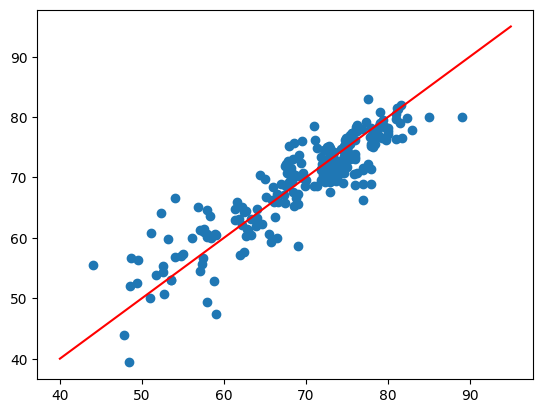

In [12]:
from sklearn.metrics import mean_squared_error
LR = LinearRegression()
LR.fit(x_train, y_train)

RMSE_val_lr = mean_squared_error(y_val, LR.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_lr:.5f}')

RMSE_test_lr = mean_squared_error(y_test, LR.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_lr:.5f}')

plt.scatter(y_val, LR.predict(x_val))
plt.plot([40,95], [40,95], 'r')
plt.show()

Samotná lineární regrese vrací relativně nízké RMSE. Zároveň se validační hodnota až moc neliší od hodnoty testovacích dat. Což je dobře, protože jinak bychom trénovali na datech, které mají jiný vztah než testovací data.

### Ridge Regression

Validační RMSE: 3.75153
Testovací RMSE: 3.17891


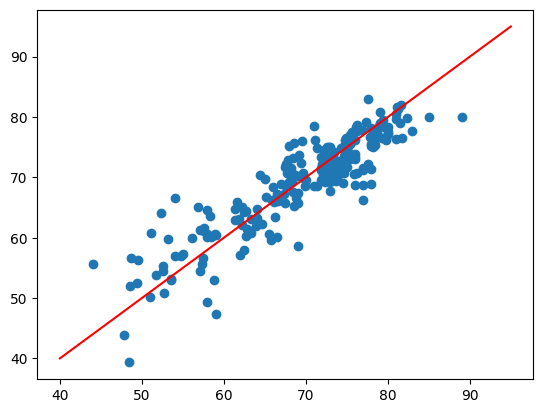

In [13]:
ridge = Ridge()
ridge.fit(x_train, y_train)

RMSE_val_ridge = mean_squared_error(y_val, ridge.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')

RMSE_test_ridge = mean_squared_error(y_test, ridge.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')

plt.scatter(y_val, ridge.predict(x_val))
plt.plot([40,95], [40,95], 'r')
plt.show()

RMSE pro Hřebenovou regresi je o nepatrně větší než u Lineární regrese. Abychom vylepšili Hřebenovou regresi, musíme optimalizovat hyperpamaretry.

### Optimalizace Ridge Regression

V této sekci optimalizujeme lambdu (v pythonu alpha) s cílem snížit RMSE.

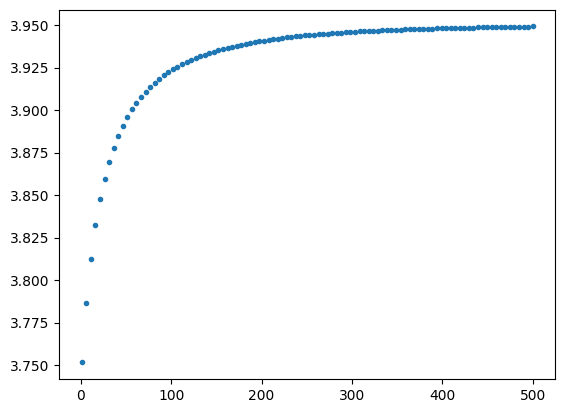

Validační RMSE: 3.74414
Testovací RMSE: 3.17066


In [14]:
from scipy import optimize

def get_opt_ridge_model(x_train, x_val):
    def ridgemodel_eval(alpha):
        clf = Ridge(alpha=alpha)
        clf.fit(x_train, y_train)
        return mean_squared_error(y_val, clf.predict(x_val), squared = False)

    alphas = np.linspace(1,500,100)
    alphas_res = [ridgemodel_eval(alpha) for alpha in alphas]
    plt.plot(alphas, alphas_res, '.')
    plt.show()

    opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))

    clf_opt_ridge = Ridge(alpha = opt_alpha.x)
    clf_opt_ridge.fit(x_train, y_train)
    return clf_opt_ridge

clf_opt_ridge = get_opt_ridge_model(x_train, x_val)
RMSE_val_opt_ridge = mean_squared_error(y_val, clf_opt_ridge.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_opt_ridge:.5f}')
RMSE_test_opt_ridge = mean_squared_error(y_test, clf_opt_ridge.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt_ridge:.5f}')

RMSE se si lehce snížilo, ale stále není lepší než RMSE u lineární regrese.

## Random Forest Regressor

Jako dodatečný model, který budu aplikovat na data jsem si vybrala Random Forest Regressor. Součástí optimalizace bude zkoumání, jaké je optimální množství stromů.

In [15]:
import sklearn.metrics as metrics
val = []
train = []
trees = range(1,100)
for tree in trees:
    rf = RandomForestRegressor(n_estimators=tree, random_state=42)
    rf.fit(x_train, y_train)
    train.append(rf.score(x_train, y_train))
    val.append(rf.score(x_val, y_val))

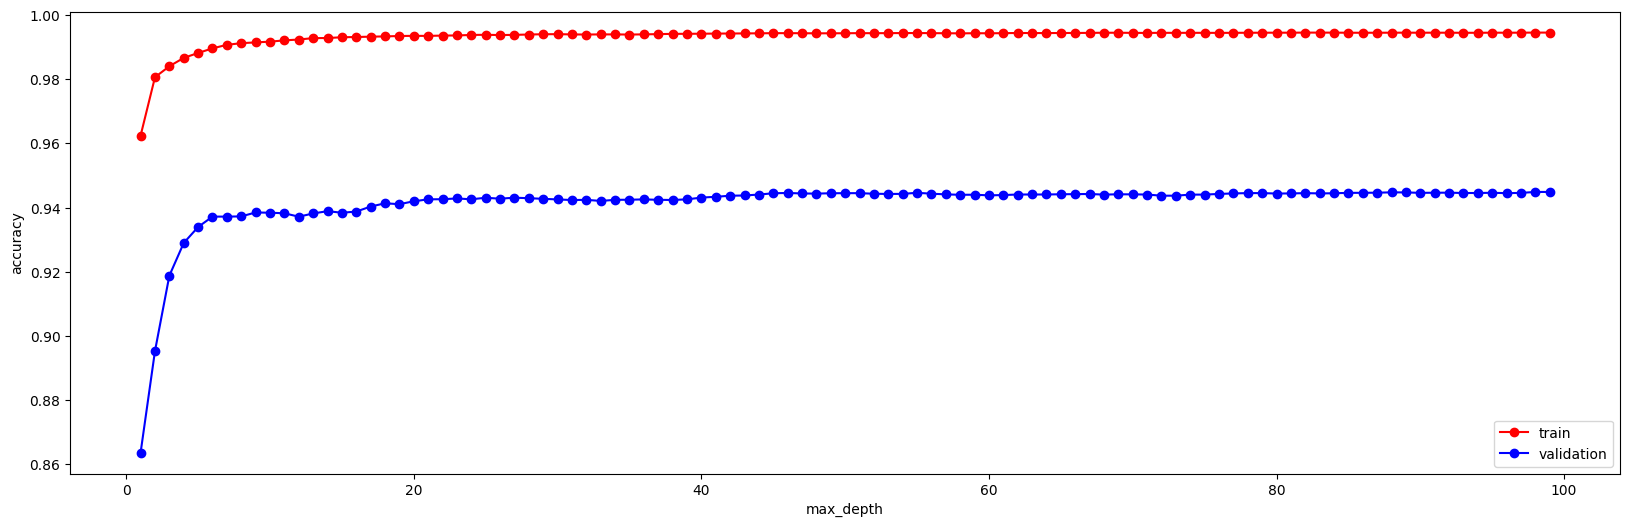

In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(trees, train,'or-')
plt.plot(trees, val,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [17]:
optimal = np.argmax(val) + 1
optimal

99

In [18]:
rf = RandomForestRegressor(n_estimators=99, random_state=42)
rf.fit(x_train, y_train)
RMSE_val_random = mean_squared_error(y_val, rf.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')

RMSE_test_random = mean_squared_error(y_test, rf.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')

Validační RMSE: 3.75153
Testovací RMSE: 3.17891


RMSE pro optimální random forest regressor je horší jak RMSE pro optimální hřebenovou regresi. Tedy vzdálenost od predikovaných bodů je dál od opravdových hodnot u Random Forest regrese než u Lineární regrese a Hřebenové regrese.

## Vytvoření nové proměnné


V této sekci jsem se snažila vypočítat, kolik každá země v daný rok investovala za zdravotnicví. V datasetu byly již údaje o tom, kolik procent ze svého GDP dá do zdravotnictví. Jelikož každá země má jiné GDP za rok, čistá informace o procentu z GDP investovaného do zdravotnicví nám sice dává informaci o tom, jak si daná země váží zdraví svých lidí, ale vyšší procento nemusí znamenat vyšší částku.

In [19]:
data['Total healthcare expenditure'] = (data['GDP']*(data['Percentage expenditure'] / 100))*data['Population']

In [20]:
data['Total healthcare expenditure'].min()

0.0

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 2937
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Year                             1649 non-null   int64  
 2   Status                           1649 non-null   bool   
 3   Life expectancy                  1649 non-null   float64
 4   Adult Mortality                  1649 non-null   float64
 5   Infant deaths                    1649 non-null   int64  
 6   Alcohol                          1649 non-null   float64
 7   Percentage expenditure           1649 non-null   float64
 8   Hepatitis B                      1649 non-null   float64
 9   Measles                          1649 non-null   int64  
 10  BMI                              1649 non-null   float64
 11  Under-five deaths                1649 non-null   int64  
 12  Polio               

In [22]:
x_train, x_val, y_train, y_val = train_test_split(data.drop(columns=['Life expectancy', 'Country']), y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.25, random_state=42)

Validační RMSE: 3.74235
Testovací RMSE: 3.17660


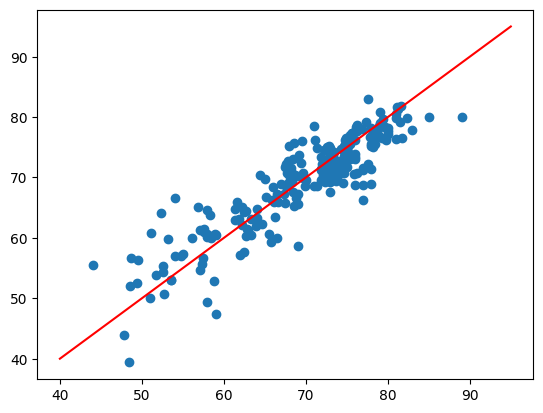

In [23]:
LR = LinearRegression()
LR.fit(x_train, y_train)

RMSE_val_lr = mean_squared_error(y_val, LR.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_lr:.5f}')

RMSE_test_lr = mean_squared_error(y_test, LR.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_lr:.5f}')

plt.scatter(y_val, LR.predict(x_val))
plt.plot([40,95], [40,95], 'r')
plt.show()

Po vytvoření nového příznaku se RMSE zhoršilo.

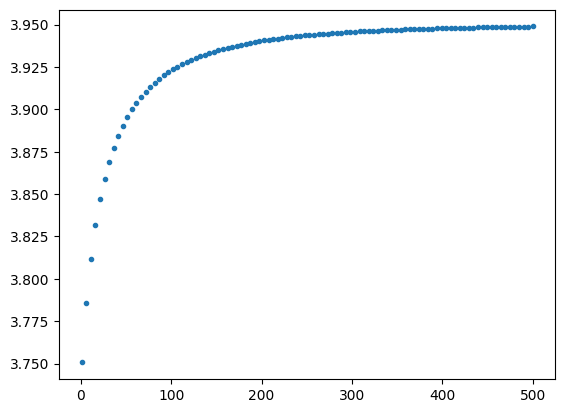

Validační RMSE: 3.74323
Testovací RMSE: 3.17730


In [24]:
clf_opt_ridge = get_opt_ridge_model(x_train, x_val)
RMSE_val_opt_ridge = mean_squared_error(y_val, clf_opt_ridge.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_opt_ridge:.5f}')
RMSE_test_opt_ridge = mean_squared_error(y_test, clf_opt_ridge.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt_ridge:.5f}')

RMSE se nijak nezměnilo.

In [25]:
rf = RandomForestRegressor(n_estimators=99, random_state=42)
rf.fit(x_train, y_train)
RMSE_val_random = mean_squared_error(y_val, rf.predict(x_val), squared = False)
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')

RMSE_test_random = mean_squared_error(y_test, rf.predict(x_test), squared = False)
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')

Validační RMSE: 3.75153
Testovací RMSE: 3.17891


RMSE se nezměnilo.

## Scaler

Součástí další analýzy je standardizace dat a následné aplikování již použitých modelů znovu za účelem zjištění, zda standardizace zlepší úspěšnost modelů.

In [26]:
scaler = StandardScaler().fit(data.drop(columns=['Life expectancy', 'Country']))
x_train_standard = scaler.transform(x_train)
x_val_standard = scaler.transform(x_val)
x_test_standard = scaler.transform(x_test)

Validační RMSE: 3.74239
Testovací RMSE: 3.17636


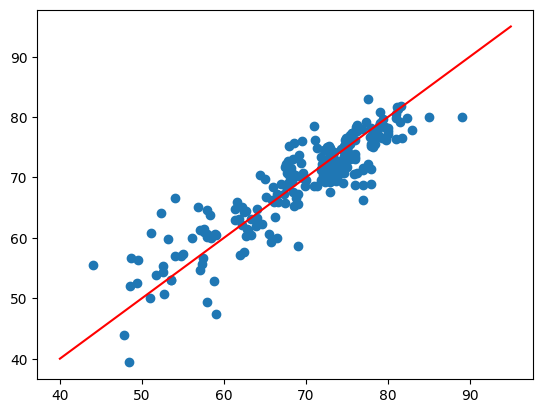

In [27]:
LR = LinearRegression()
LR.fit(x_train_standard, y_train)

RMSE_val_lr = mean_squared_error(y_val, LR.predict(x_val_standard), squared = False)
print(f'Validační RMSE: {RMSE_val_lr:.5f}')

RMSE_test_lr = mean_squared_error(y_test, LR.predict(x_test_standard), squared = False)
print(f'Testovací RMSE: {RMSE_test_lr:.5f}')

plt.scatter(y_val, LR.predict(x_val_standard))
plt.plot([40,95], [40,95], 'r')
plt.show()

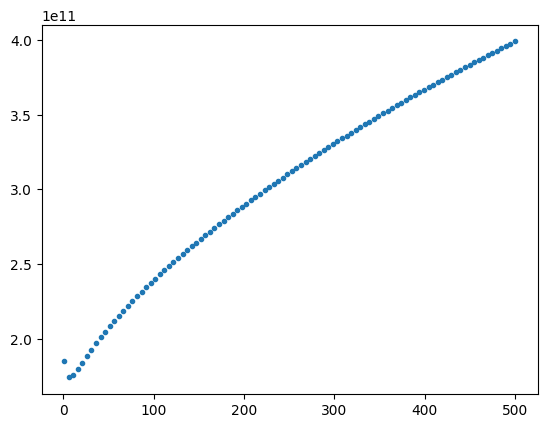

Validační RMSE: 3.74795
Testovací RMSE: 3.22803


In [28]:
clf_opt_ridge = get_opt_ridge_model(x_train_standard, x_val)
RMSE_val_opt_ridge = mean_squared_error(y_val, clf_opt_ridge.predict(x_val_standard), squared = False)
print(f'Validační RMSE: {RMSE_val_opt_ridge:.5f}')
RMSE_test_opt_ridge = mean_squared_error(y_test, clf_opt_ridge.predict(x_test_standard), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt_ridge:.5f}')

In [29]:
rf = RandomForestRegressor(n_estimators=99, random_state=42)
rf.fit(x_train_standard, y_train)
RMSE_val_random = mean_squared_error(y_val, rf.predict(x_val_standard), squared = False)
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')

RMSE_test_random = mean_squared_error(y_test, rf.predict(x_test_standard), squared = False)
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')

Validační RMSE: 3.75153
Testovací RMSE: 3.17891


Standardizace lehce zhorší RMSE u Hřebenové regrese, ale na ostatní modely nemá (v tomto případě) velký efekt.